In [1]:
import os
import yaml
import joblib
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split

from model import CINN
from plot_utils import (
    load_model_and_data,
    sample_posteriors,
    compute_map_estimates,
    build_priors_from_training,
)



In [2]:
TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri']


TARGET_UNITS = [
    r'$\mathrm{Gyr}$',                # last_T_coll
    r'$\mathrm{km/s}$',               # last_V_coll
    r'$10^{14}\,M_\odot$',            # last_M_Crit500_coll
    r'$10^{14}\,M_\odot$',            # last_Subcluster_mass
    r'' ,                             # last_Mass_ratio (unitless)
    r'$\mathrm{kpc}$',                # last_d_peri        
]


In [6]:
def normalize_fname(fname):
    base = os.path.splitext(os.path.basename(fname))[0]
    import re
    m = re.match(r"^snap_(\d+)_halo_(\d+)_proj_(\d+)$", base)
    if not m:
        raise ValueError(f"Unexpected filename: {base}")
    snap, halo, proj = map(int, m.groups())
    return f"{halo}_{snap}_{proj}"

def posterior_distribution(
    model_checkpoint: str,
    params_path: str,
    processed_dir: str = "processed_data",
    emb_path: str = "embeddings.npy",
    fname_path: str = "filenames.npy",
    n_rows: int = 10,
    n_samples: int = 600,
    random_state: int = 42,
    select_halo_ids: list = None,
    select_snapshots: list = None
):
    """
    Rewritten to use the new pipeline (embeddings → cINN → features),
    with column titles on the first row and, on the last row,
    numeric x‐axis ticks (5 evenly spaced) plus a two‐line label
    (name on the first line, unit on the second). All other rows hide x‐ticks.
    """

    # ─── 1) Load model, embeddings, Y‐scaled, and scaler ─────────────────────────────
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model, E_full, Y_full_rep, tar_sc = load_model_and_data(
        model_checkpoint=model_checkpoint,
        params_path=params_path,
        processed_dir=processed_dir,
        device=device
    )
    # E_full: (N_proj, D_emb)
    # Y_full_rep: (N_proj, D_tar_scaled)

    # ─── 2) Reconstruct meta_rep (one row per “projection”) ───────────────────────────
    df_meta = pd.read_csv(os.path.join(processed_dir, "meta.csv"))
    projs = [1, 2, 3]
    meta_rep = pd.concat([df_meta.assign(proj=p) for p in projs], ignore_index=True)
    # Now meta_rep.shape[0] == E_full.shape[0] == Y_full_rep.shape[0]

    N, D_emb = E_full.shape
    D_tar = Y_full_rep.shape[1]
    if D_tar != len(TARGET_COLS):
        raise ValueError(f"D_tar={D_tar} but len(TARGET_COLS)={len(TARGET_COLS)}")

    # ─── 3) Train/Test split on indices [0 .. N-1] ──────────────────────────────────
    idx = np.arange(N)
    idx_tmp, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    val_frac = 0.1 / 0.9
    idx_train, idx_val = train_test_split(idx_tmp, test_size=val_frac, random_state=random_state)

    E_test = E_full[idx_test]              # (N_test, D_emb)
    Y_test = Y_full_rep[idx_test]          # (N_test, D_tar_scaled)
    meta_test = meta_rep.iloc[idx_test].reset_index(drop=True)

    # ─── 4) Pick which “n_rows” test‐projections to plot ────────────────────────────
    if select_halo_ids is not None and select_snapshots is not None:
        if len(select_halo_ids) != len(select_snapshots):
            raise ValueError("HaloIDs and Snapshots lists must match length")
        chosen = []
        for hid, snap in zip(select_halo_ids, select_snapshots):
            matches = meta_test[
                (meta_test["HaloID"] == hid) & (meta_test["Snapshot"] == snap)
            ].index
            if len(matches) == 0:
                raise ValueError(f"No test entry for HaloID={hid}, Snapshot={snap}")
            chosen.append(int(matches[0]))
    else:
        rng = np.random.RandomState(random_state)
        chosen = rng.choice(len(E_test), size=n_rows, replace=False).tolist()

    n_rows = len(chosen)
    E_chosen = E_test[chosen]             # (n_rows, D_emb)
    Y_chosen = Y_test[chosen]             # (n_rows, D_tar_scaled)
    meta_chosen = meta_test.iloc[chosen].reset_index(drop=True)

    # ─── 5) Sample posterior & compute MAP & true‐value (physical units) ─────────────
    post_phys = sample_posteriors(model, E_chosen, tar_sc,
                                  n_samples=n_samples, device=device)
    # post_phys: (n_rows, n_samples, D_tar_phys)

    maps_phys = compute_map_estimates(post_phys)       # (n_rows, D_tar_phys)
    true_phys = tar_sc.inverse_transform(Y_chosen)     # (n_rows, D_tar_phys)

    # Build priors from entire test set (physical units)
    Y_test_phys = tar_sc.inverse_transform(Y_test)     # (N_test, D_tar_phys)
    priors = build_priors_from_training(Y_test_phys)   # list of (grid, pdf) tuples, length D_tar

    # ─── 6) BEGIN PLOTTING ─────────────────────────────────────────────────────────────
    fig, axes = plt.subplots(
        n_rows, D_tar,
        figsize=(3 * D_tar, 1.25 * n_rows),
        sharex="col",
        squeeze=False
    )
    # Extra room at top for column titles and bottom for two‐line labels + ticks
    plt.subplots_adjust(left=0.07, right=0.97, top=0.88, bottom=0.18, wspace=0.1, hspace=0.2)

    for i_row in range(n_rows):
        # Left‐most label (Snapshot / HaloID) with fontsize=8
        axes[i_row, 0].text(
            -0.15, 0.5,
            f"{meta_chosen['Snapshot'][i_row]}\n{meta_chosen['HaloID'][i_row]}",
            transform=axes[i_row, 0].transAxes,
            rotation=90, va="center", ha="center", fontsize=8
        )
        for d in range(D_tar):
            ax = axes[i_row, d]
            g_prior, pd_prior = priors[d]

            # 1) Plot prior
            ax.fill_between(g_prior, pd_prior, color="lightgrey", alpha=0.6)
            ax.plot(g_prior, pd_prior, "k--", lw=1)

            # 2) Plot posterior KDE
            samp = post_phys[i_row, :, d][:, None]
            kde2 = KernelDensity(kernel="gaussian", bandwidth=0.6).fit(samp)
            g_post = np.linspace(samp.min(), samp.max(), 200)[:, None]
            pd_post = np.exp(kde2.score_samples(g_post))
            pd_post /= pd_post.max()
            ax.plot(g_post.ravel(), pd_post, color="C0", lw=2)

            # 3) Plot MAP (gold) & truth (red)
            ax.axvline(maps_phys[i_row, d], color="gold", lw=1.5)
            ax.axvline(true_phys[i_row, d], color="red", lw=1.5)

            # 4) Axes limits
            ax.set_xlim(g_prior.min(), g_prior.max())
            ax.set_ylim(0, None)

            # 5) X‐axis: show ticks and two‐line label on last row only
            if i_row == n_rows - 1:
                # compute 5 evenly spaced ticks between min and max
                tick_vals = np.linspace(g_prior.min(), g_prior.max(), 5)
                ax.set_xticks(tick_vals)
                ax.set_xticklabels([f"{t:.2f}" for t in tick_vals], fontsize=8, rotation=45)

                # Two‐line label: name on first line, unit on second line
                ax.set_xlabel(
                    f"{TARGET_COLS[d]}\n({TARGET_UNITS[d]})",
                    fontsize=10
                )
            else:
                # hide ticks and tick labels for non‐bottom rows
                ax.set_xticks([])

            # 6) Column titles on the first row, just outside via pad
            if i_row == 0:
                ax.set_title(
                    TARGET_COLS[d],
                    fontsize=10,
                    pad=10
                )

            # 7) Hide y‐axis ticks entirely
            ax.set_yticks([])

    plt.tight_layout()
    plt.savefig("1.posterior_distribution.png", dpi=300)
    #plt.savefig("1.posterior_distribution.pdf", dpi=300)
    plt.show()

/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


num samples out of bounds: 0
number of parameters: 1761976
GraphINN(
  (module_list): ModuleList(
    (0-7): 8 x RationalQuadraticSplineBlock(
      (softplus): Softplus(beta=0.5, threshold=20.0)
      (subnet): Subnet(
        (layers): Sequential(
          (0): Linear(in_features=515, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
          (4): Linear(in_features=256, out_features=87, bias=True)
        )
      )
    )
  )
)


/vera/u/jshera/CINN_spline/representation_space/plot_utils.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


num samples out of bounds: 0
number of parameters: 1761976
GraphINN(
  (module_list): ModuleList(
    (0-7): 8 x RationalQuadraticSplineBlock(
      (softplus): Softplus(beta=0.5, threshold=20.0)
      (subnet): Subnet(
        (layers): Sequential(
          (0): Linear(in_features=515, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
          (4): Linear(in_features=256, out_features=87, bias=True)
        )
      )
    )
  )
)
num samples out of bounds: 0
number of parameters: 1761976
GraphINN(
  (module_list): ModuleList(
    (0-7): 8 x RationalQuadraticSplineBlock(
      (softplus): Softplus(beta=0.5, threshold=20.0)
      (subnet): Subnet(
        (layers): Sequential(
          (0): Linear(in_features=515, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
          (4): Linear(in_features=256, out_

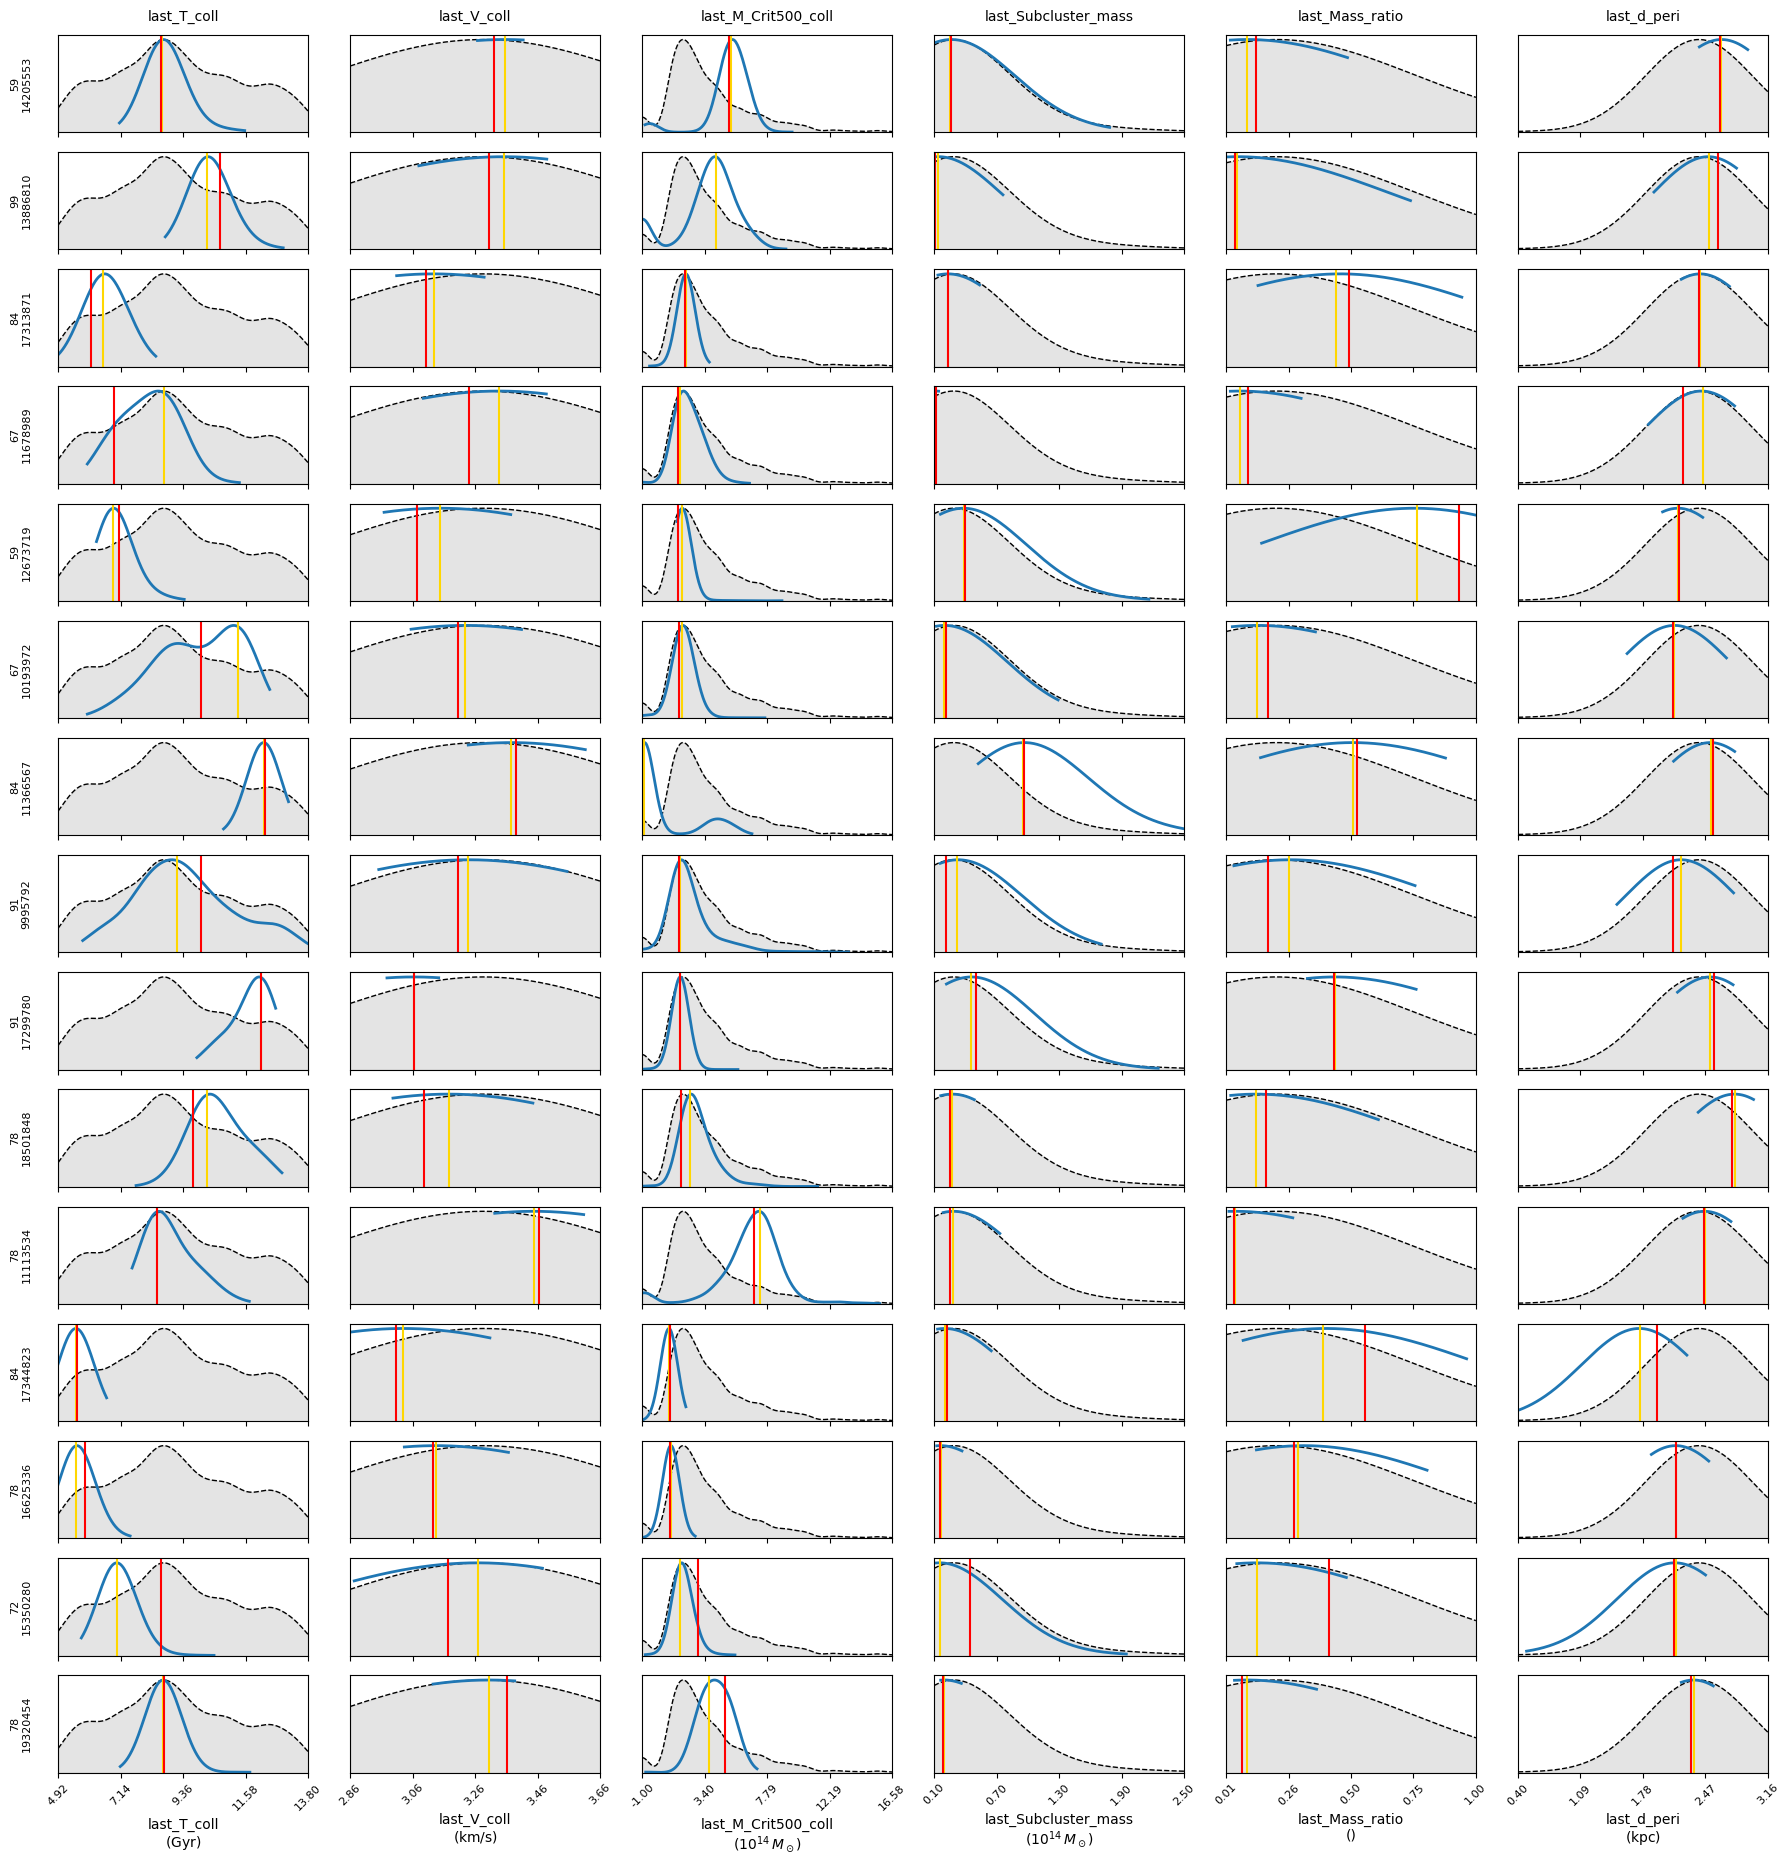

In [7]:
posterior_distribution(
    model_checkpoint="experts/",
    params_path="params.yaml",
    processed_dir="processed_data",
    emb_path="embeddings.npy",
    fname_path="filenames.npy",
    n_rows=15,
    n_samples=1000
)